In [23]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os 

import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, DE_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int
from ff_energy.ffe.plot import *

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

from numpyro.infer import Predictive

plt.rcParams['axes.facecolor'] = 'white'



plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.11.0")




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
_c = next(read_from_pickle("ff/kmdcm_pbe0dz_clusters.ff.pkl"))
_p = next(read_from_pickle("ff/kmdcm_pbe0dz_pairs.ff.pkl"))
_c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()
_c.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs
test0,-173.022645,test0,24.14023,-104.500664,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-88.423162,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917
test1,-105.096240,test1,25.25058,-63.376251,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.572842,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093
test2,-144.567121,test2,24.75756,-89.301399,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-74.628103,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225
test3,-105.558619,test3,21.75948,-62.555107,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-59.373736,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989
test4,-141.957058,test4,21.69034,-90.244034,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-74.612483,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-95.007202,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-76.747423,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665
test496,-126.839243,test496,15.65968,-75.305267,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-58.484893,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412
test497,-160.377711,test497,20.65947,-90.769882,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-58.307082,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865
test498,-154.210967,test498,21.38907,-87.210403,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-64.986090,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222


In [307]:
_c = next(read_from_pickle("ff/pc_pbe0dz_clusters.ff.pkl"))
_p = next(read_from_pickle("ff/pc_pbe0dz_pairs.ff.pkl"))
_c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()
_c.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs
test0,-173.022645,test0,24.14023,-86.464790,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-88.423162,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917
test1,-105.096240,test1,25.25058,-55.362144,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.572842,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093
test2,-144.567121,test2,24.75756,-76.750671,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-74.628103,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225
test3,-105.558619,test3,21.75948,-60.453758,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-59.373736,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989
test4,-141.957058,test4,21.69034,-77.184944,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-74.612483,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.597740,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-76.747423,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665
test496,-126.839243,test496,15.65968,-71.282913,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-58.484893,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412
test497,-160.377711,test497,20.65947,-76.301025,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-58.307082,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865
test498,-154.210967,test498,21.38907,-73.317917,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-64.986090,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222


In [308]:
_p.data["epol_pairs"] = _c.data["epol_pairs"].copy()
_p.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-88.423162,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.572842,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-74.628103,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-59.373736,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-74.612483,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-76.747423,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-58.484893,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-58.307082,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-64.986090,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222


In [309]:
print(_p)
print(_c)

FF: LJ water_cluster ELEC harmonic P_intE (jax_coloumb: True)
FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)


In [310]:
_c.data["intE"] + _c.data["ELEC"]
_c.data["C_ENERGY_kcalmol"] 

test0     -958370.381547
test1     -958336.157791
test2     -958360.493844
test3     -958352.359334
test4     -958367.030618
               ...      
test495   -958357.505436
test496   -958363.074582
test497   -958353.280867
test498   -958358.525003
test499   -958366.401571
Name: C_ENERGY_kcalmol, Length: 500, dtype: float64

In [14]:
pd.DataFrame(_c.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
1,31.733431,483,837,0,True,Optimization terminated successfully.,"[0.2500167996552497, 1.6623296208473117, 0.463...","([[0.2500167996552497, 1.6623296208473117, 0.4..."
2,31.910048,918,1485,0,True,Optimization terminated successfully.,"[0.25246755650191777, 1.7509865433149945, 0.13...","([[0.25246755650191777, 1.7509865433149945, 0...."
4,36.300903,1259,2009,0,True,Optimization terminated successfully.,"[2.5, 1.771883075308752, 0.0001000007156202719...","([[2.5, 1.771883075308752, 0.00010000071562027..."
0,126.497955,58,231,0,True,Optimization terminated successfully.,"[0.25, 0.33096178797670994, 0.2110533071935053...","([[0.25, 0.33096178797670994, 0.21105330719350..."
3,126.497955,72,233,0,True,Optimization terminated successfully.,"[0.28127925202783866, 0.29840114156286157, 0.2...","([[0.28127925202783866, 0.29840114156286157, 0..."


In [11]:
_c.get_best_parm()

array([ 0.2500168 ,  1.66232962,  0.46303839,  0.22080418, 10.37576407,
       11.02930408])

In [36]:
_c.intern = "Exact"
_c.set_intE()
_c.set_targets()
print(np.mean(_c.targets))
_p.intern = "Exact"
_p.set_intE()
_p.set_targets()
print(np.mean(_p.targets))

82.83116
20.216446


In [37]:
_c = next(read_from_pickle("ff/pc_pbe0dz_clusters.ff.pkl"))
_p = next(read_from_pickle("ff/pc_pbe0dz_pairs.ff.pkl"))
_c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()

fit_repeat(_c, 
           10, 
           None,
           bounds=DE_bound,
           loss="jax_de",
           quiet='true'
          )
# pd.DataFrame(_c.opt_results).sort_values("fun")
# fit_repeat(_p, 
#            5, 
#            None,
#            bounds=DE_bound,
#            loss="jax_de",
#            quiet='true'
#           )
# pd.DataFrame(_p.opt_results).sort_values("fun")
numpyro_mse_plot(_p, _c.get_best_parm())
numpyro_mse_plot(_c, _c.get_best_parm())
# numpyro_mse_plot(_p, _p.get_best_parm())
# numpyro_mse_plot(_c, _p.get_best_parm())

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  tol=1e-6,


KeyboardInterrupt: 

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  tol=1e-6,
sample: 100%|█| 6000/6000 [00:07<00:00, 774.91it/s, 31 steps of size 1.89e-01. acc. prob=0.


3.540667208049354e-297
{'MSE': 10.70806621209265, 'RMSE': 3.2723181709749207, 'R': 0.9667776039954533, 'RS': 0.9625253861015444, 'n': 500, 'slope': 1.0278183500806077, 'intercept': 0.0982003377399252}


sample: 100%|█| 6000/6000 [00:07<00:00, 815.22it/s, 15 steps of size 2.19e-01. acc. prob=0.


7.666684235216456e-256
{'MSE': 18.35486761616119, 'RMSE': 4.284258117359549, 'R': 0.9509177301244433, 'RS': 0.9452741170964684, 'n': 500, 'slope': 0.8108780307537377, 'intercept': -11.196805223453133}


<Figure size 2400x2400 with 0 Axes>

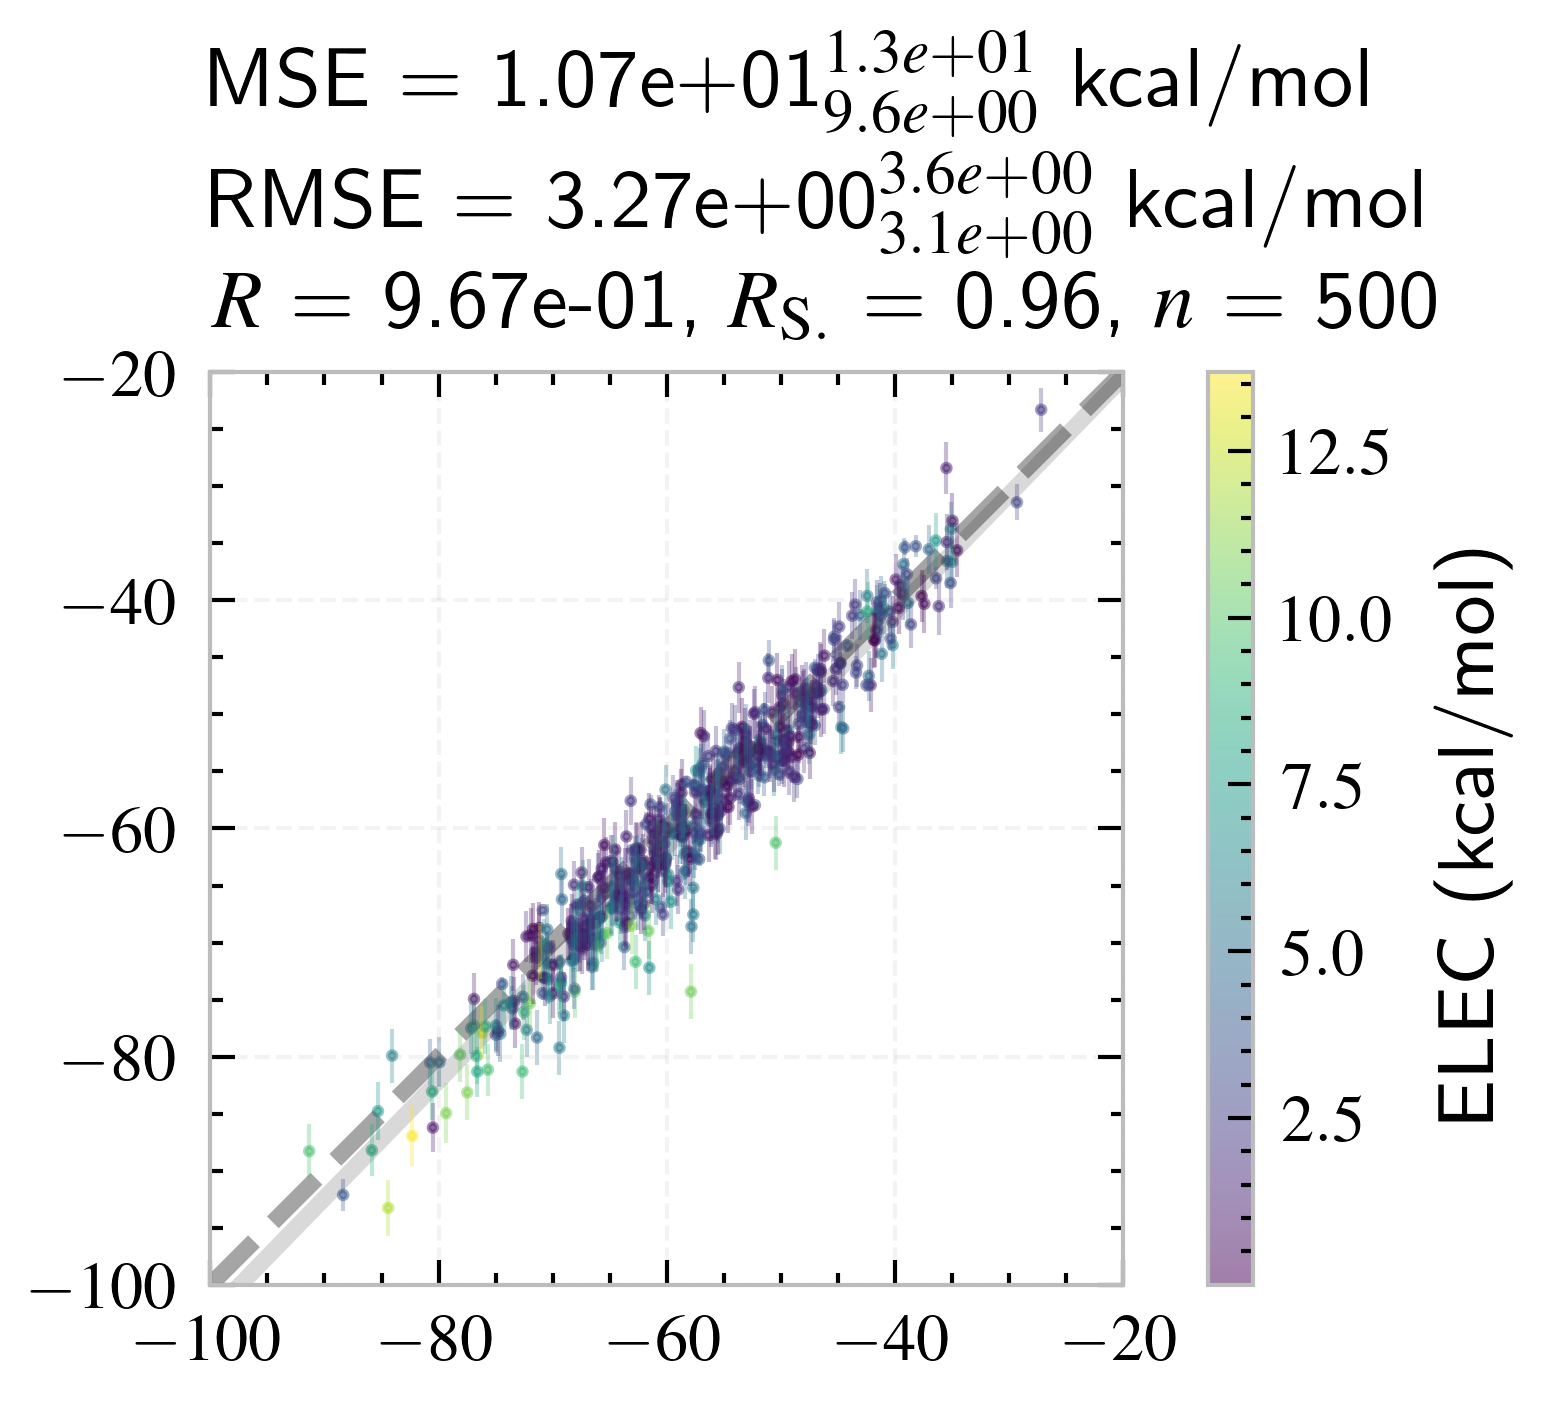

<Figure size 2400x2400 with 0 Axes>

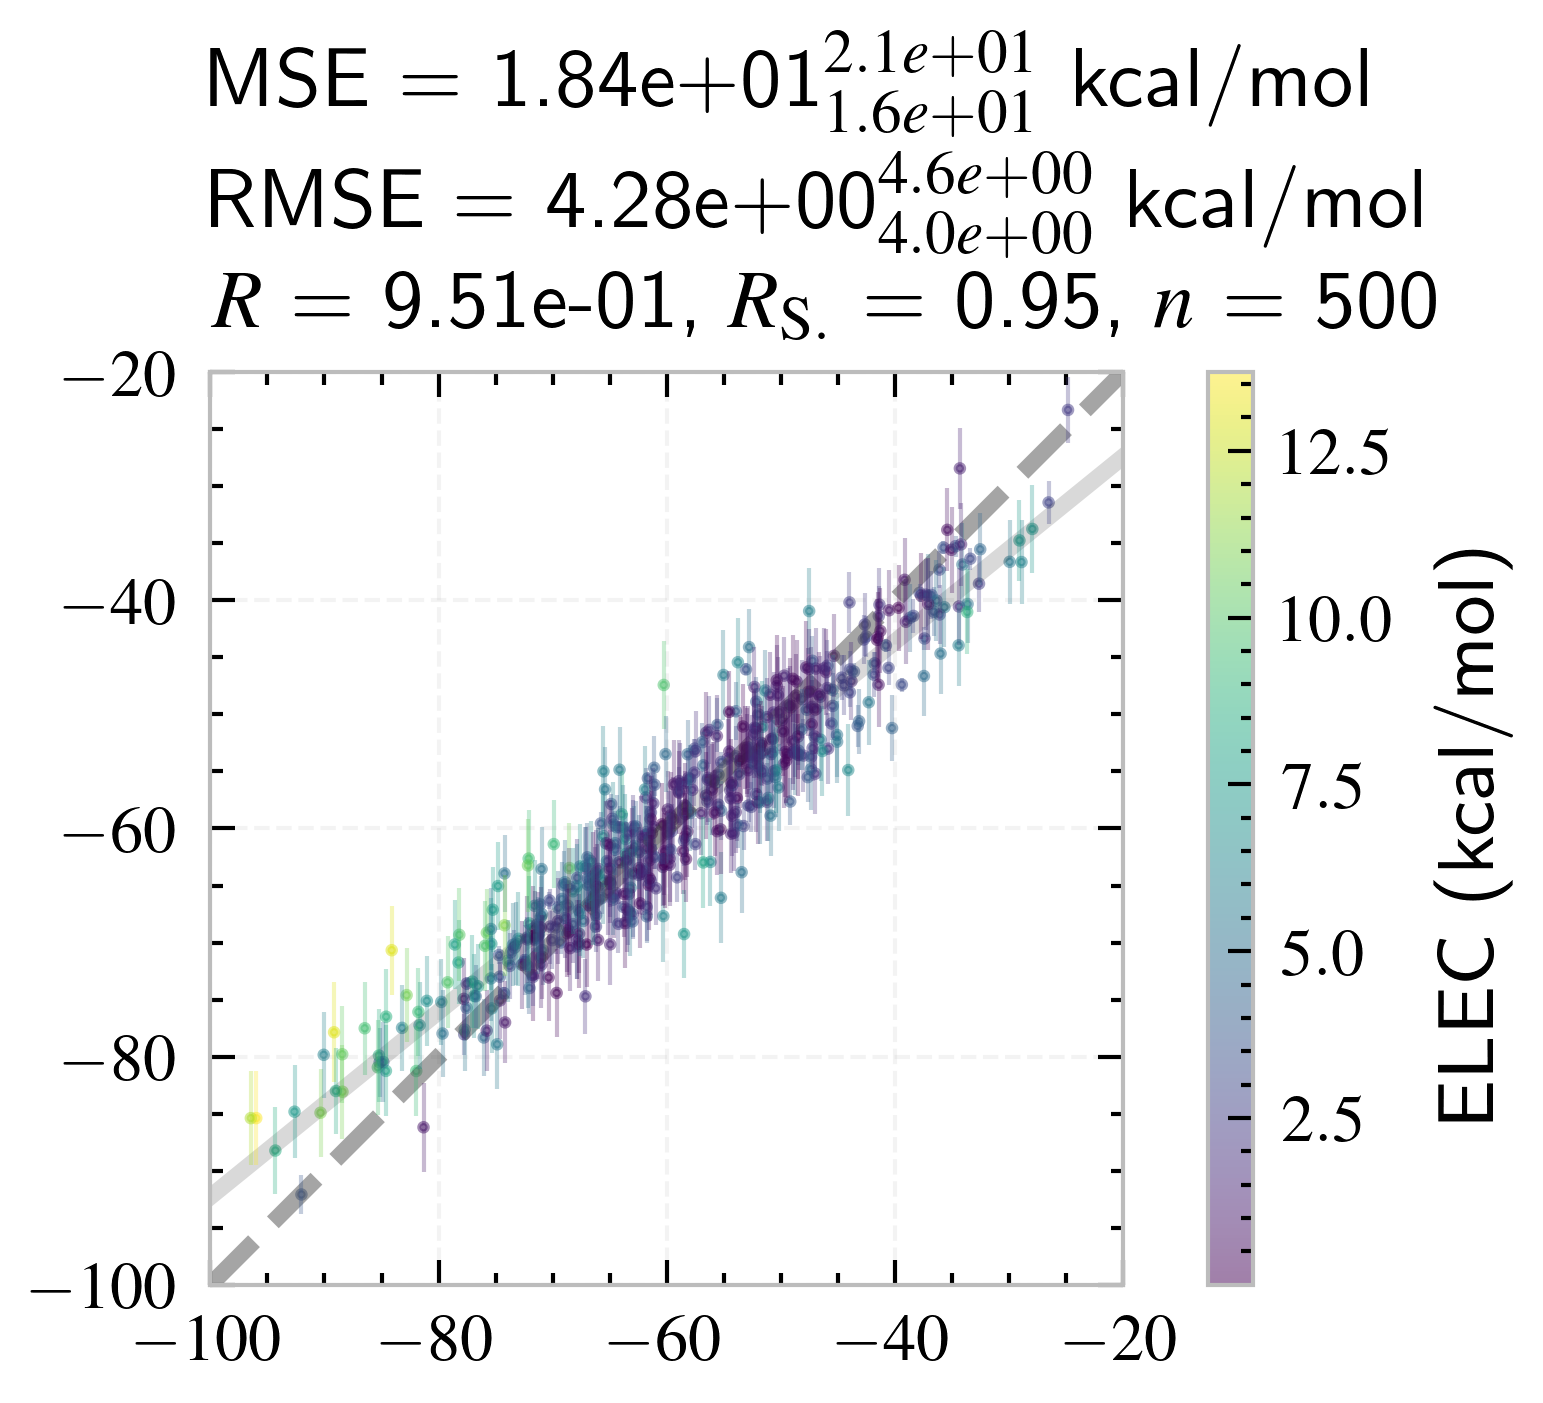

In [29]:
_c = next(read_from_pickle("ff/mdcm_pbe0dz_clusters.ff.pkl"))
_p = next(read_from_pickle("ff/mdcm_pbe0dz_pairs.ff.pkl"))
_c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()

fit_repeat(_c, 
           10, 
           None,
           bounds=DE_bound,
           loss="jax_de",
           quiet='true'
          )
# pd.DataFrame(_c.opt_results).sort_values("fun")
# fit_repeat(_p, 
#            5, 
#            None,
#            bounds=DE_bound,
#            loss="jax_de",
#            quiet='true'
#           )
# pd.DataFrame(_p.opt_results).sort_values("fun")
numpyro_mse_plot(_p, _c.get_best_parm())
numpyro_mse_plot(_c, _c.get_best_parm())
# numpyro_mse_plot(_p, _p.get_best_parm())
# numpyro_mse_plot(_c, _p.get_best_parm())

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  tol=1e-6,
sample: 100%|█| 6000/6000 [00:07<00:00, 788.76it/s, 15 steps of size 2.11e-01. acc. prob=0.


7.6336672e-316
{'MSE': 9.607638053871094, 'RMSE': 3.099619017536041, 'R': 0.9721197135098215, 'RS': 0.9701517526070104, 'n': 500, 'slope': 1.0451453652341565, 'intercept': 1.1300263615998531}


sample: 100%|█| 6000/6000 [00:07<00:00, 768.23it/s, 31 steps of size 2.03e-01. acc. prob=0.


1.4993948783171048e-255
{'MSE': 18.103921792007498, 'RMSE': 4.254870361363258, 'R': 0.9507819350619668, 'RS': 0.9463140892563568, 'n': 500, 'slope': 0.8192528705579251, 'intercept': -10.683653958266355}


<Figure size 2400x2400 with 0 Axes>

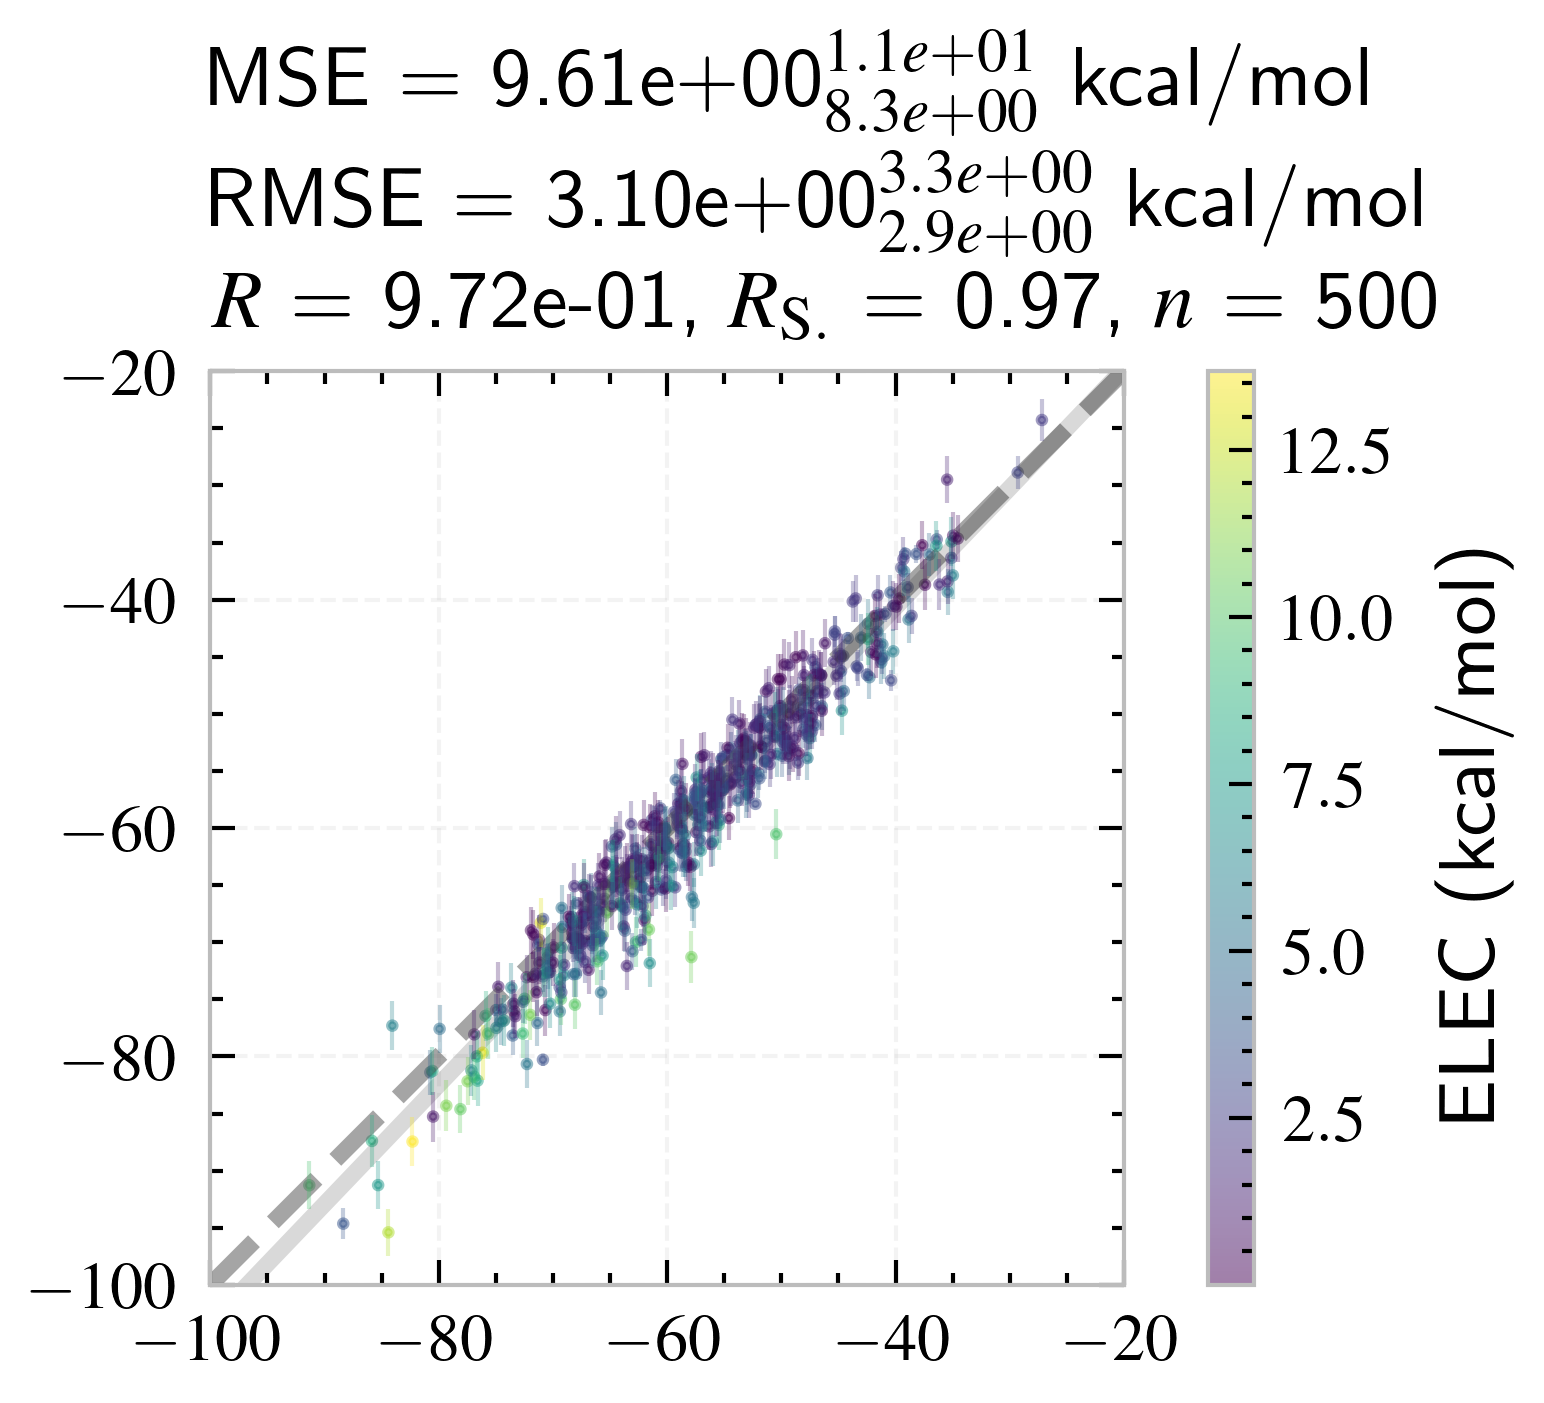

<Figure size 2400x2400 with 0 Axes>

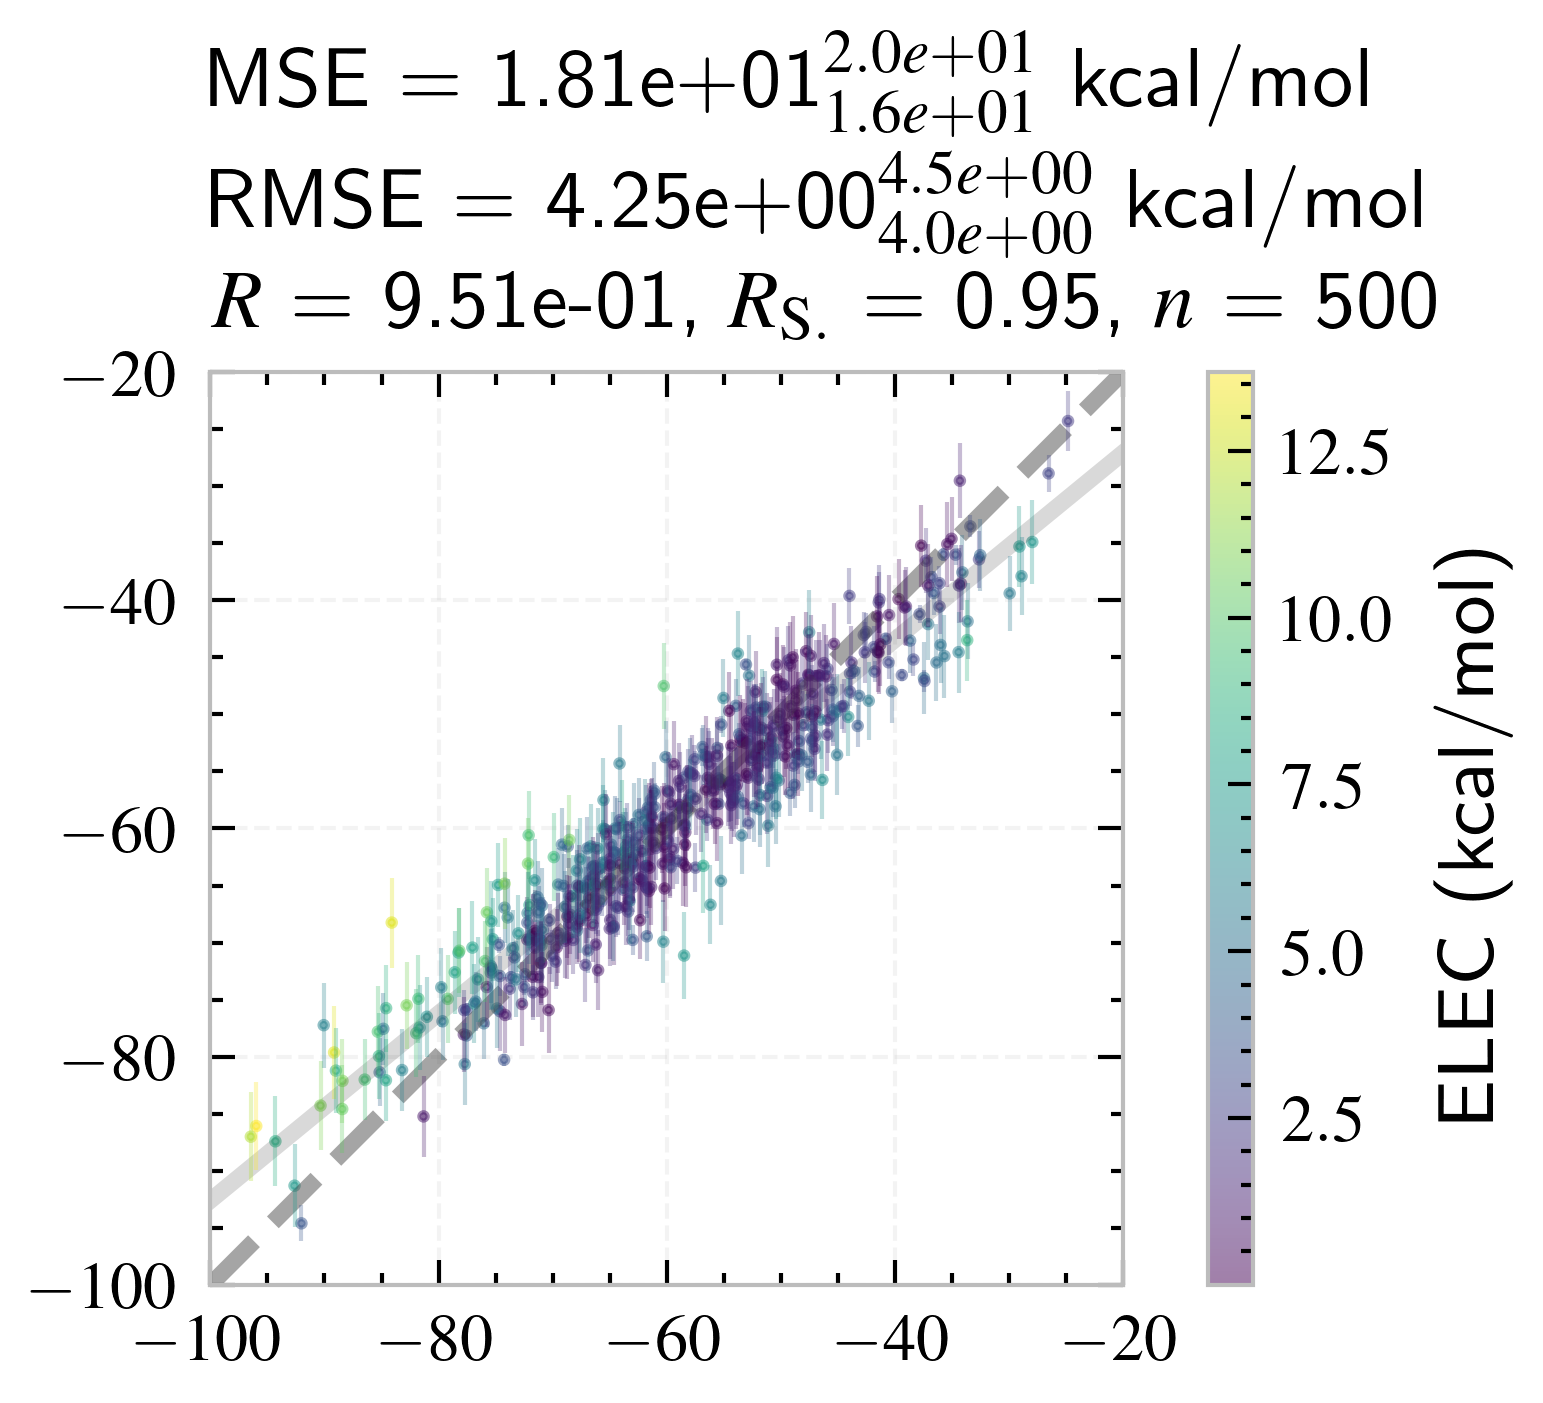

In [31]:
_c = next(read_from_pickle("ff/kmdcm_pbe0dz_clusters.ff.pkl"))
_p = next(read_from_pickle("ff/kmdcm_pbe0dz_pairs.ff.pkl"))
_c.get_loss_coulomb([1])
_c.data["epol_mike"] = _p.data["epol_mike"].copy()

fit_repeat(_c, 
           10, 
           None,
           bounds=DE_bound,
           loss="jax_de",
           quiet='true'
          )
# pd.DataFrame(_c.opt_results).sort_values("fun")
# fit_repeat(_p, 
#            5, 
#            None,
#            bounds=DE_bound,
#            loss="jax_de",
#            quiet='true'
#           )
# pd.DataFrame(_p.opt_results).sort_values("fun")
numpyro_mse_plot(_p, _c.get_best_parm())
numpyro_mse_plot(_c, _c.get_best_parm())
# numpyro_mse_plot(_p, _p.get_best_parm())
# numpyro_mse_plot(_c, _p.get_best_parm())

In [111]:
TARGETS = _c.targets

#  pairs

In [298]:
_p

FF: LJ water_cluster ELEC harmonic P_intE (jax_coloumb: True)

In [22]:
# numpyro_mse_plot(_p, _c.get_best_parm())
# numpyro_mse_plot(_c, _c.get_best_parm())

# Residual error

In [114]:
residuals_hpdi = hpdi(_c.data["RESIDUALS"])
residuals_hpdi
error = residuals_hpdi[1] - _c.data["RESIDUALS"].mean()
error

6.7512693

In [115]:
# _c.data["manybody_diff"] = (_c.data["epol_mike"] - _c.data["epol_pairs"] ).abs() 
_c.data["manybody_diff"] = (_c.data["intE"] - _c.data["P_intE"] ).abs() 
_c.data[["intE", "manybody_diff", "epol_mike", "TARGET"]]

,intE,manybody_diff,epol_mike,TARGET
test0,-88.423162,10.944940,-197.910658,16.077499
test1,-53.572842,0.287041,-113.959761,9.803410
test2,-74.628103,3.742114,-160.484782,14.673294
test3,-59.373736,0.710844,-118.662845,3.181370
test4,-74.612483,1.241299,-155.773808,15.631554
...,...,...,...,...
test495,-76.747423,4.136185,-175.806320,18.259781
test496,-58.484893,2.634021,-138.410126,16.820374
test497,-58.307082,0.346639,-178.929213,32.462799
test498,-64.986090,0.484763,-171.903376,22.224312


(-40.0, 40.0)

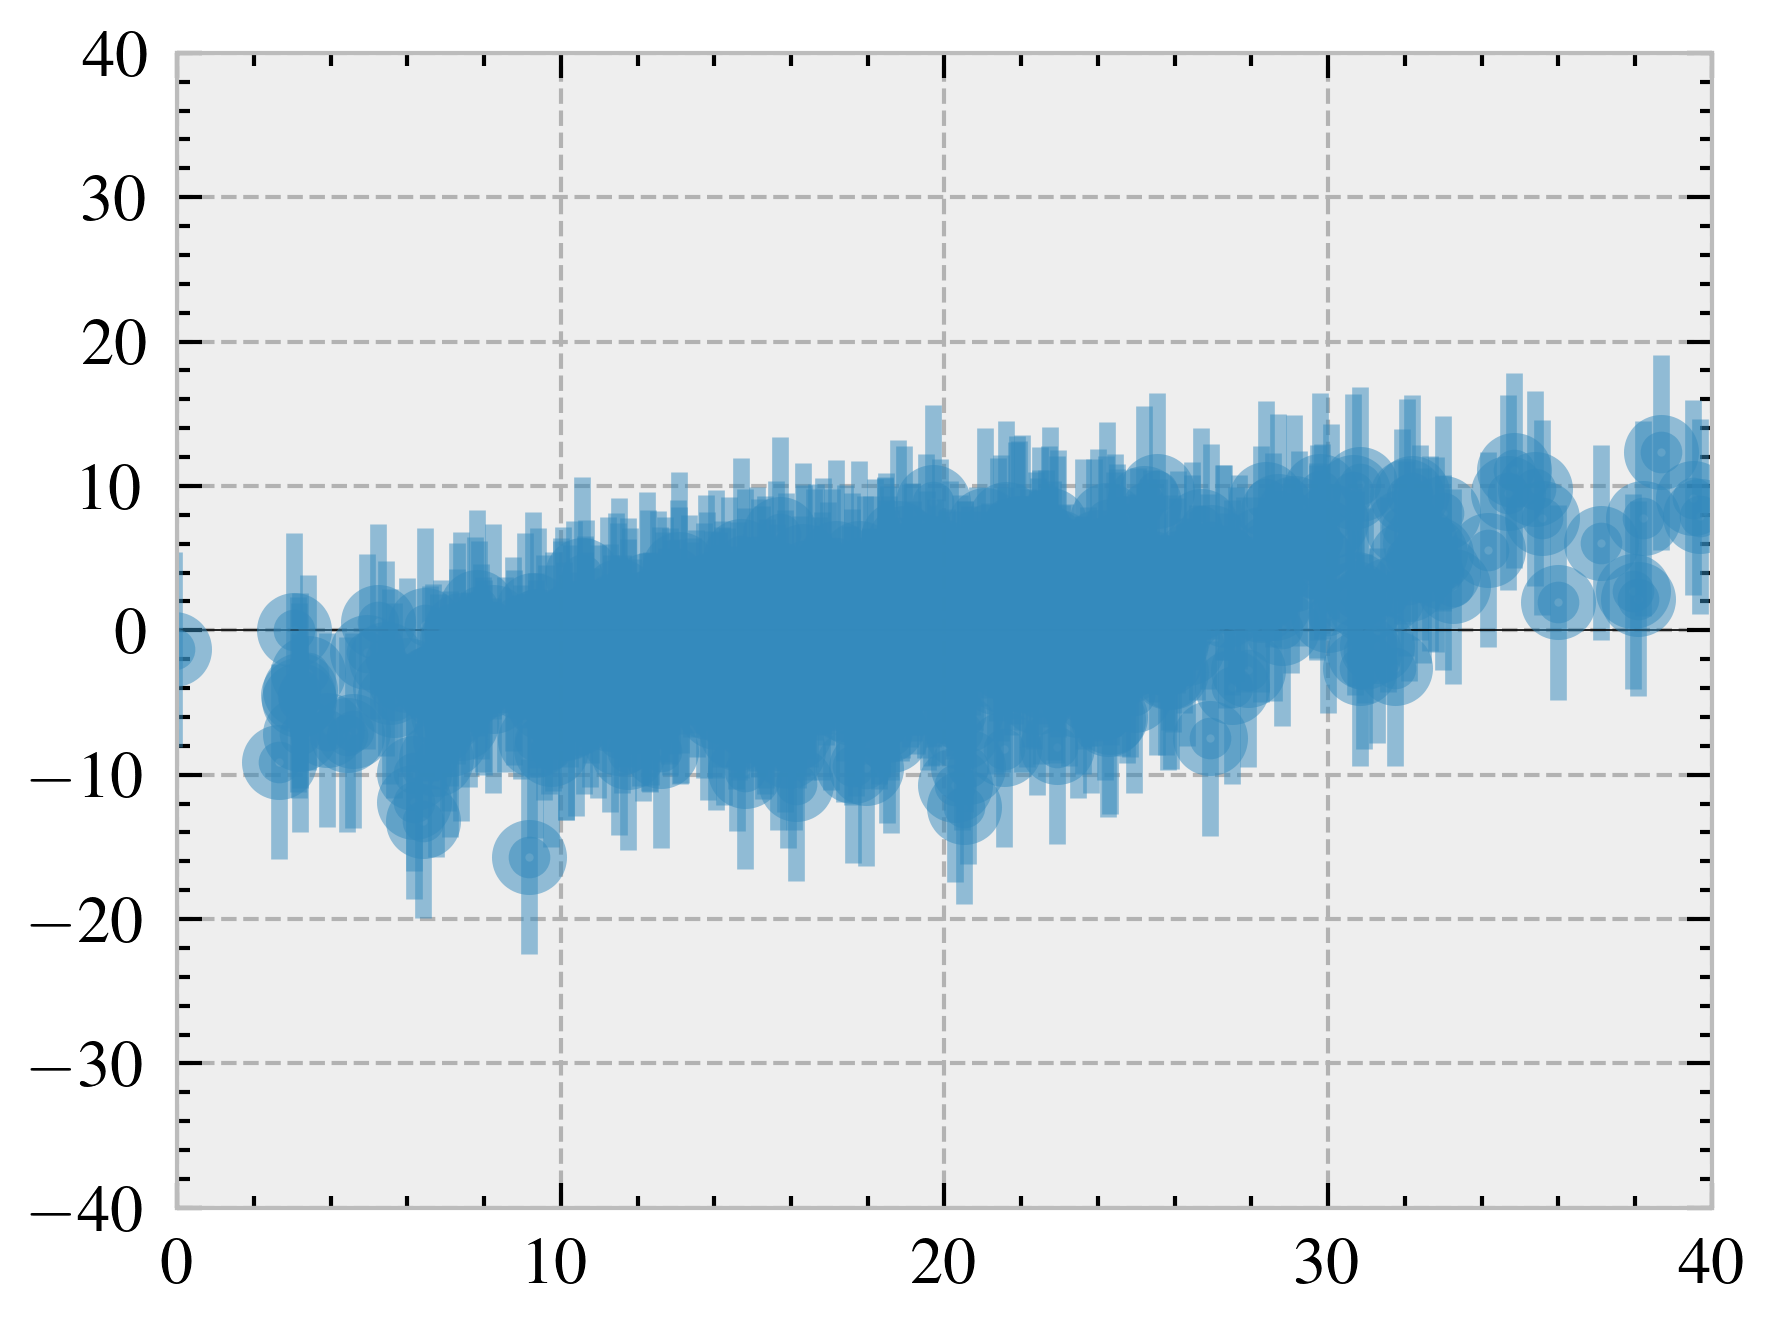

In [222]:
plt.errorbar(_c.data["TARGET"], _c.data["RESIDUALS"], yerr=error, marker="o", ms=5, mew=4, ls="none", alpha=0.5)
plt.axhline(0, c="k", linewidth=0.2)
plt.xlim(0,40)
plt.ylim(-40,40)

Text(0, 0.5, 'Pairs - Cluster polarization [kcal/mol]')

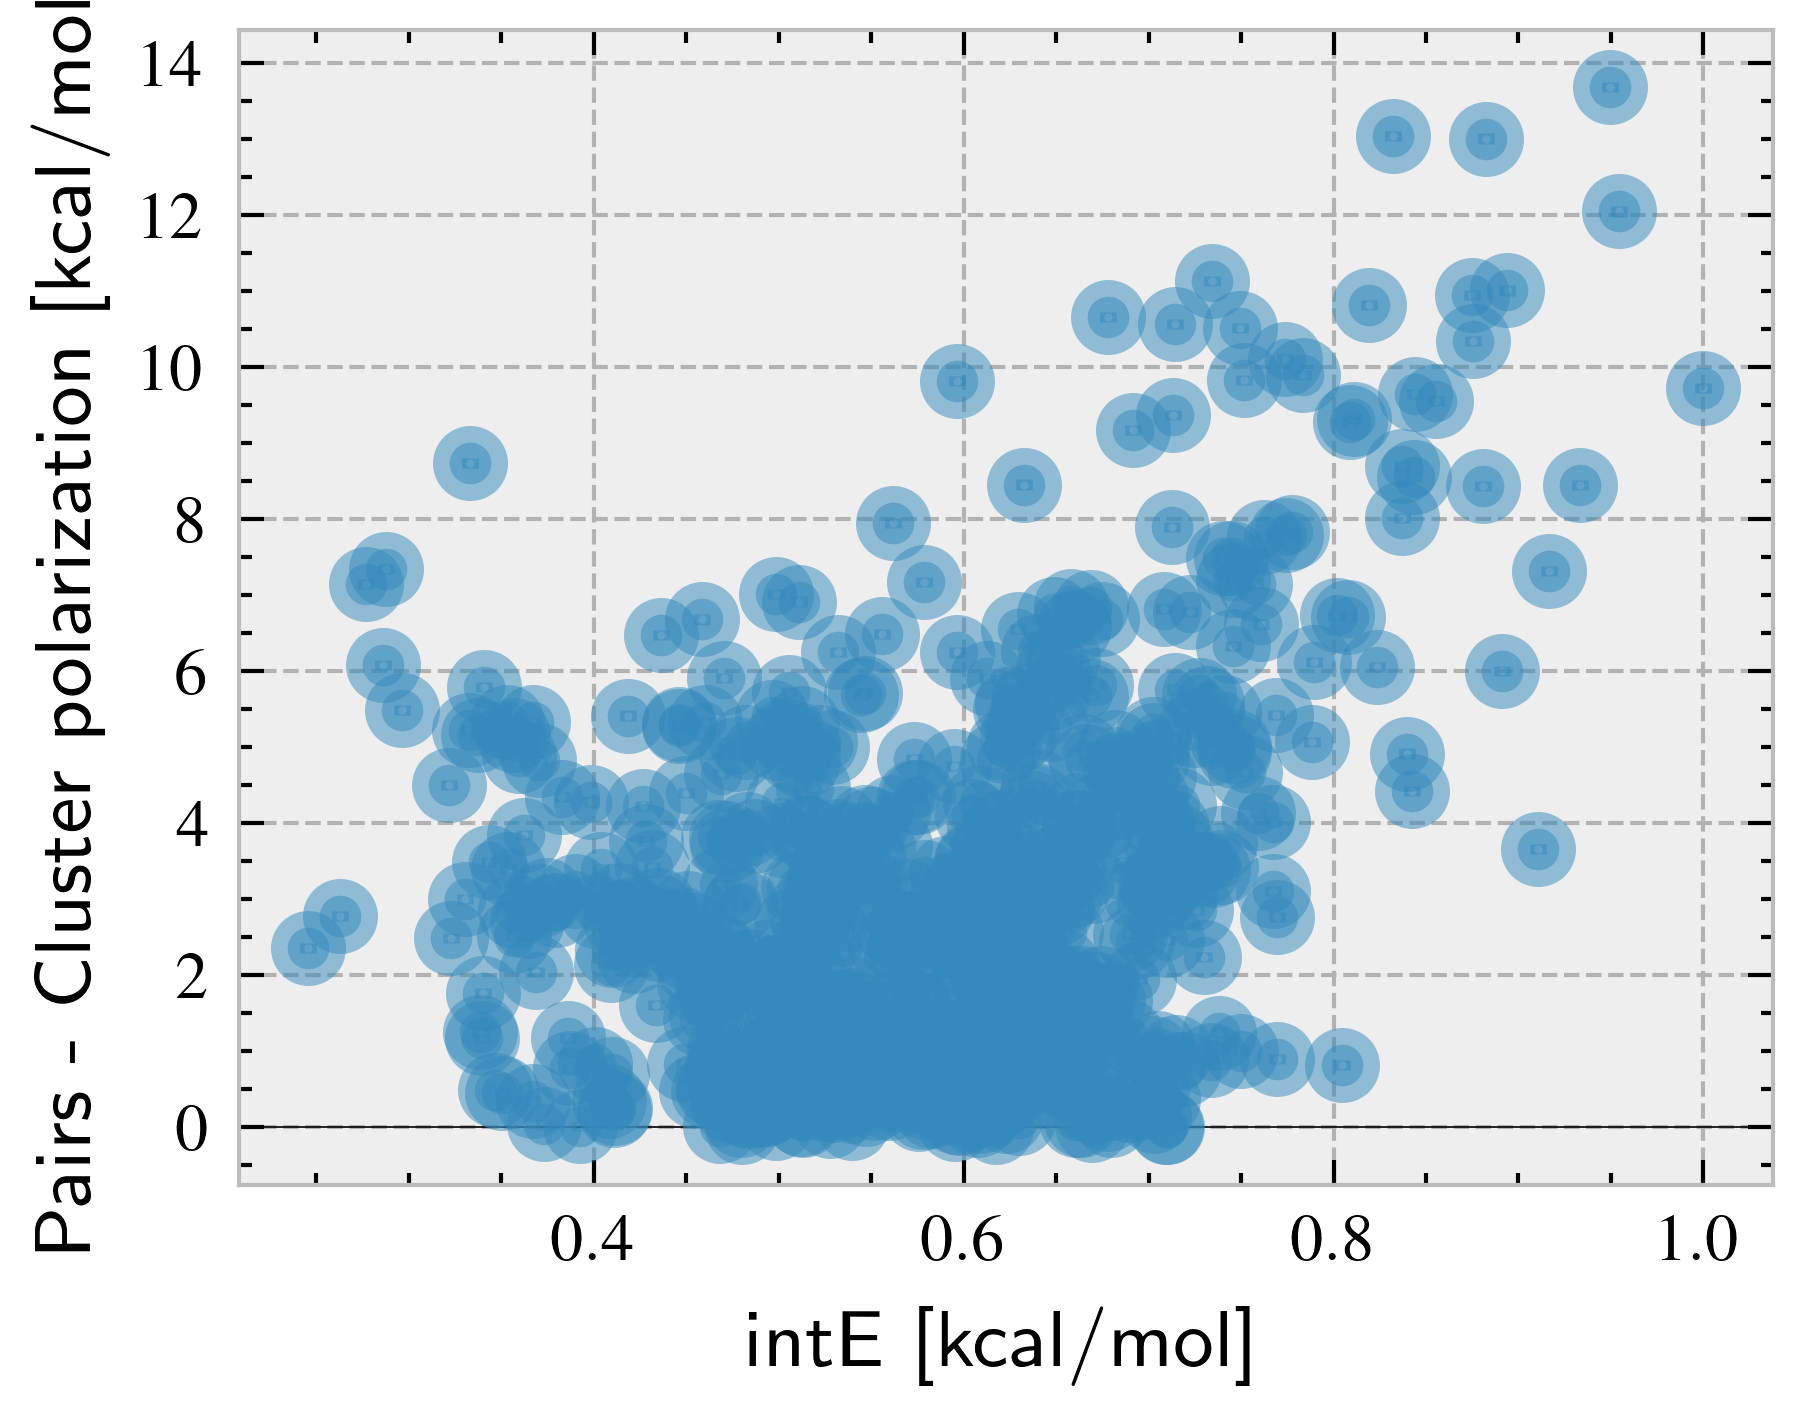

In [223]:
plt.errorbar(_c.data["intE"]/_c.data["intE"].min(), _c.data["manybody_diff"], yerr=-error/_c.data["intE"].min(), marker="o", ms=5, mew=4, ls="none", alpha=0.5)
plt.axhline(0, c="k", linewidth=0.2)
plt.xlabel("intE [kcal/mol]")
plt.ylabel("Pairs - Cluster polarization [kcal/mol]")

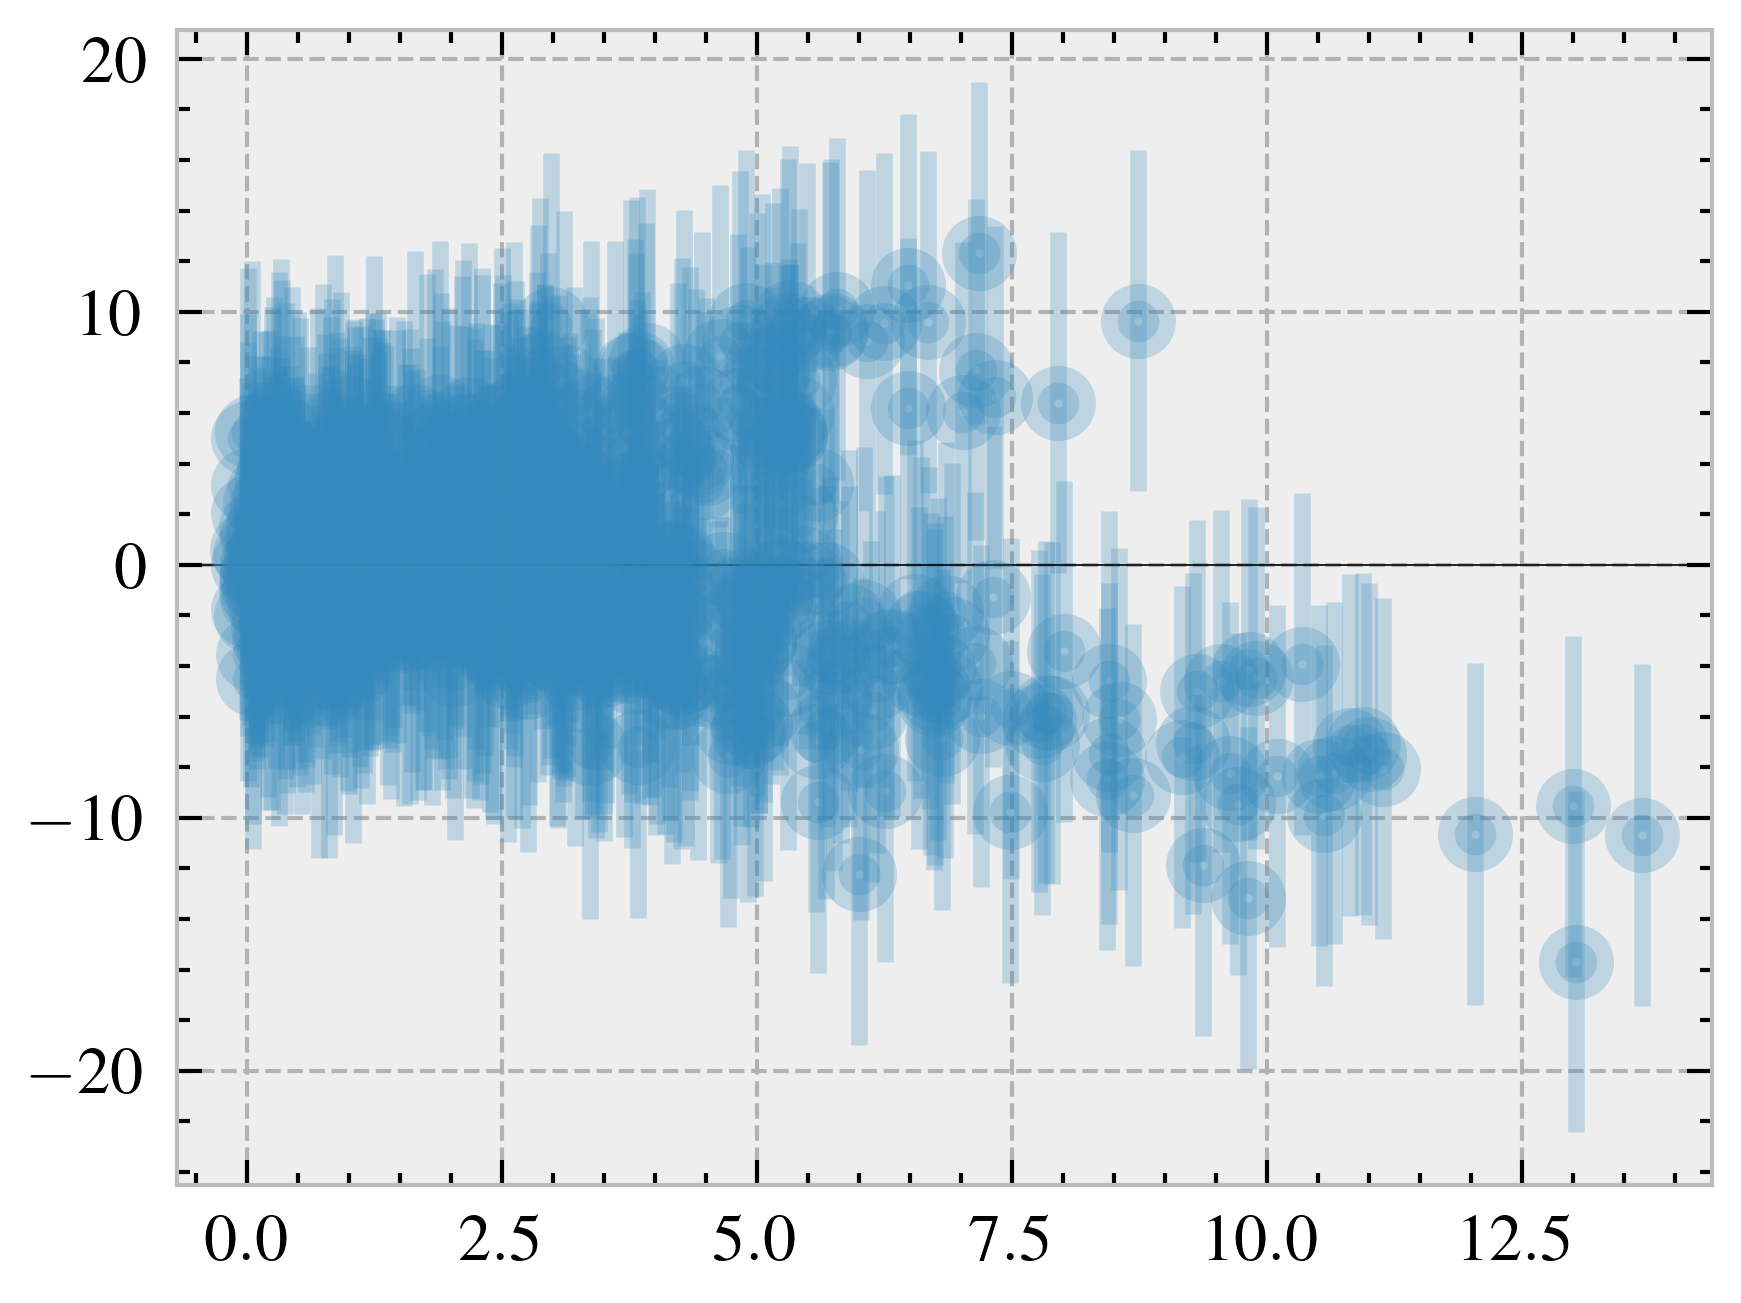

In [118]:
plt.errorbar(_c.data["manybody_diff"], _c.data["RESIDUALS"], yerr=error, marker="o", ms=5, mew=4, ls="none", alpha=0.25)
plt.axhline(0, c="k", linewidth=0.2)
# plt.xlim(-0.2, 0)

(array([  3.,  15.,  66.,  95., 107.,  99.,  66.,  33.,  13.,   3.]),
 array([ 1.2262615 ,  4.91811943,  8.60997772, 12.30183506, 15.99369335,
        19.68555069, 23.37740898, 27.06926727, 30.76112366, 34.45298386,
        38.14484024]),
 <BarContainer object of 10 artists>)

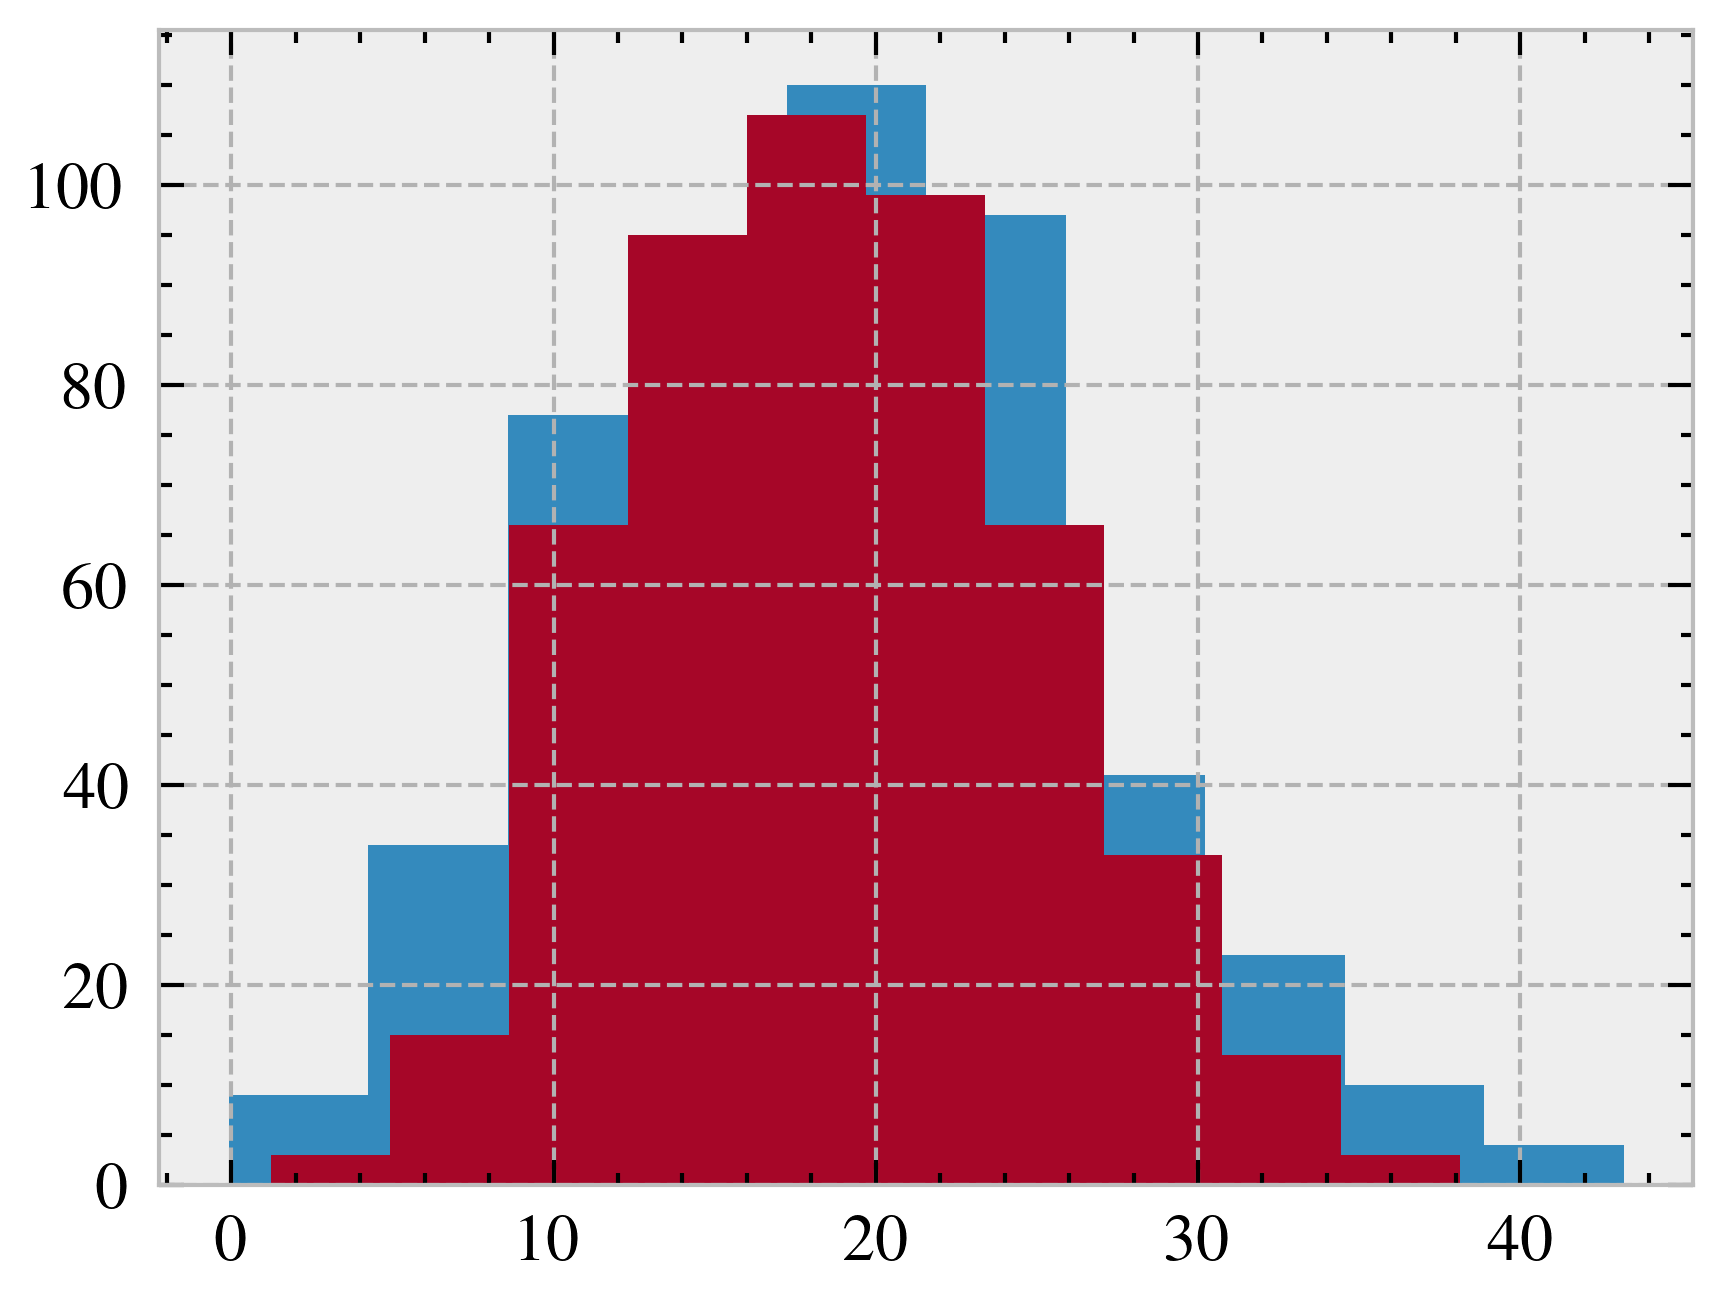

In [119]:
# plt.scatter(TARGETS, FIT)
plt.hist(TARGETS)
plt.hist(FIT)
# plt.hist(_p.targets)

(array([  2.,   4.,  18.,  40., 106., 138., 108.,  55.,  20.,   9.]),
 array([-15.68276978, -12.88239288, -10.08201599,  -7.28163958,
         -4.48126316,  -1.68088627,   1.11949039,   3.91986704,
          6.72024393,   9.52062035,  12.32099724]),
 <BarContainer object of 10 artists>)

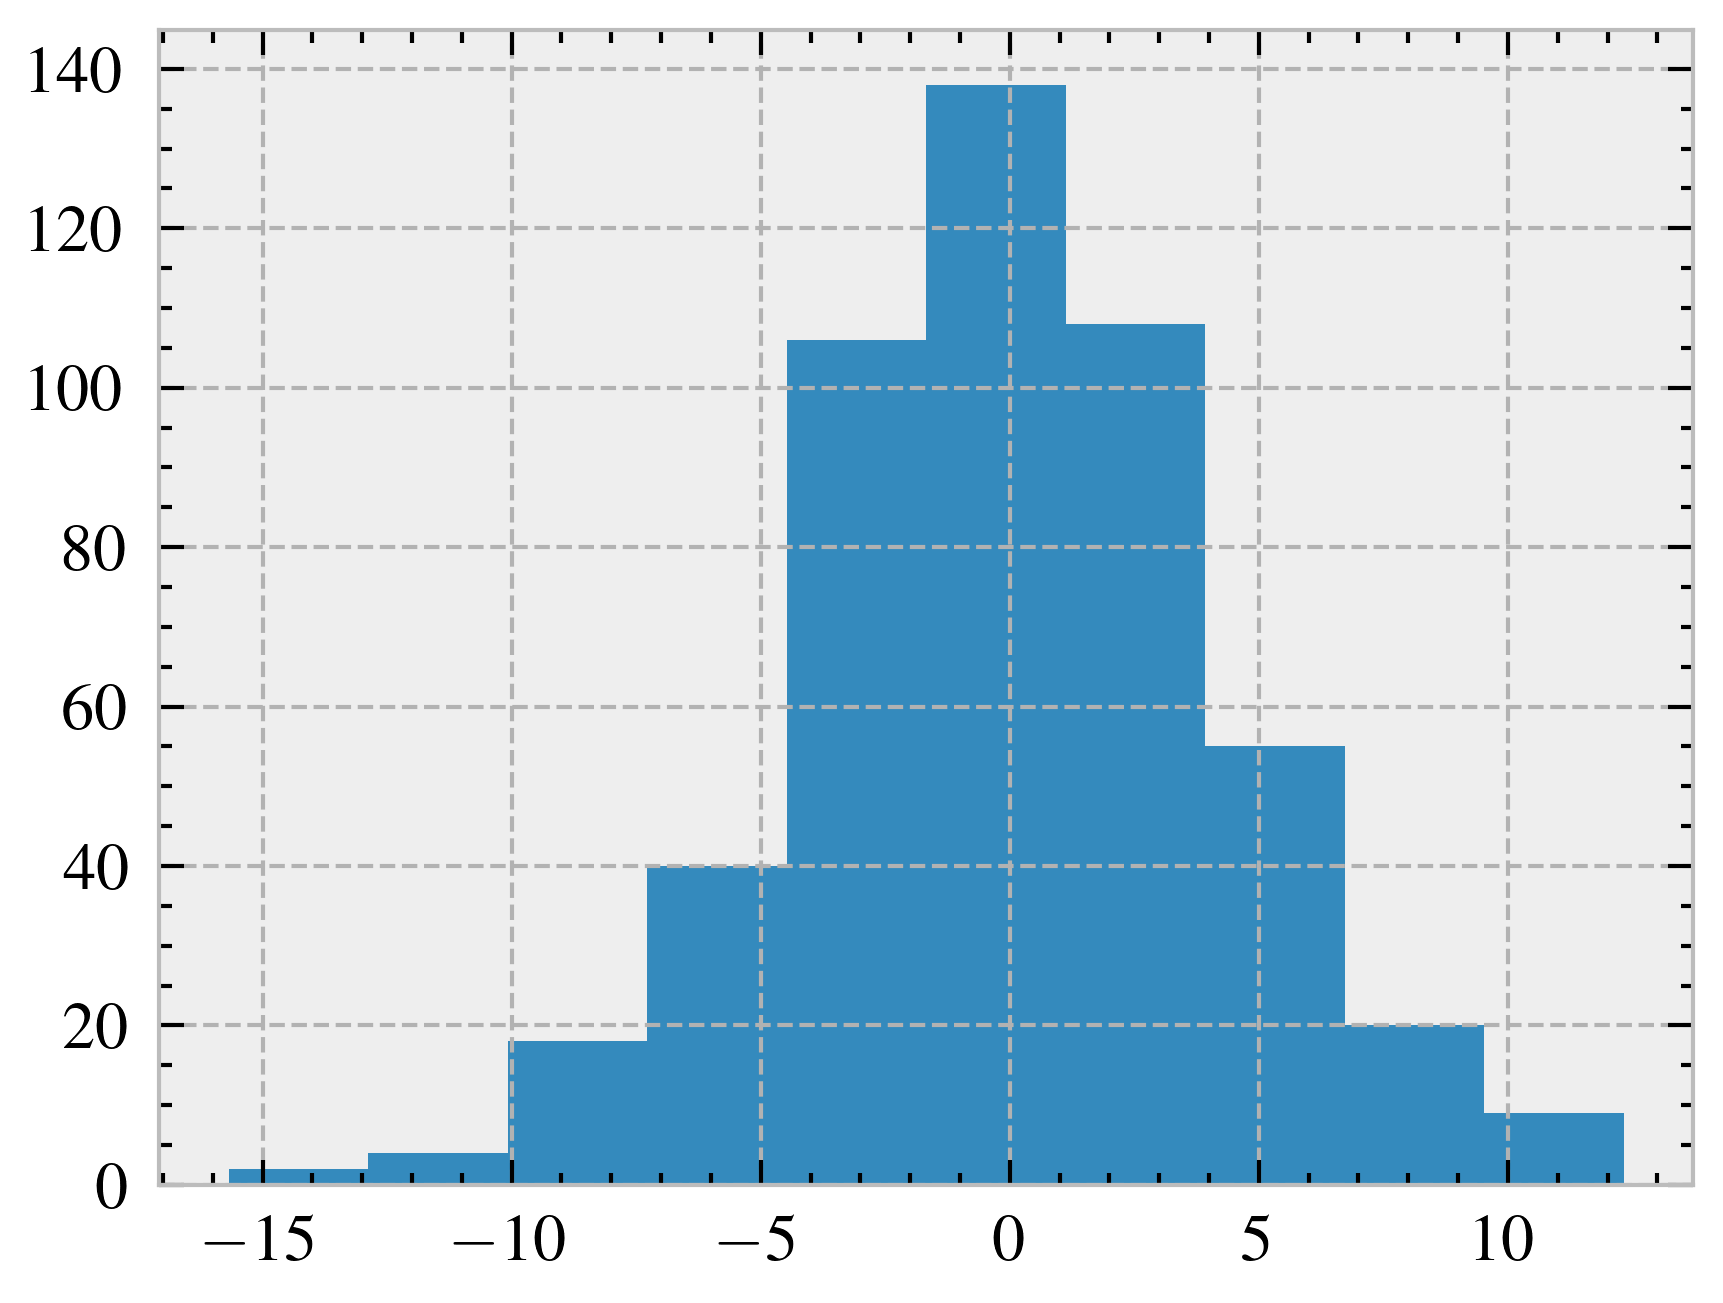

In [120]:
plt.hist(_c.data["RESIDUALS"])

In [121]:
_c.data.sort_values("manybody_diff")

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,epol_mike,first_order_energy,epol_pairs,TARGET,FIT,RESIDUALS,manybody_diff,TARGETScaled,FITScaled,manybody_diff_S
test96,-163.434955,test96,25.18816,-93.693893,18.10955,test96,-1527.131558,test96,20,-1527.246828,...,-184.426493,15.267872,-177.383602,21.938766,21.324802,0.613964,0.000248,0.425357,0.417318,0.000009
test154,-146.055696,test154,23.13233,-80.534073,24.37931,test154,-1527.146492,test154,20,-1527.225388,...,-162.716316,37.165004,-157.443576,32.039257,27.046537,4.992720,0.007181,1.762422,1.334378,0.000248
test86,-139.743055,test86,20.08965,-84.615097,11.85451,test86,-1527.151348,test86,20,-1527.267792,...,-154.653014,-16.084613,-149.146001,12.895882,14.696362,-1.800480,0.007353,-0.771706,-0.644964,0.000254
test209,-150.806393,test209,19.53957,-87.370842,19.71245,test209,-1527.158897,test209,20,-1527.260085,...,-166.508541,11.463023,-160.687820,24.944347,22.908245,2.036102,0.007556,0.823225,0.671978,0.000261
test340,-73.217959,test340,26.24033,-42.733219,1.35009,test340,-1527.136802,test340,20,-1527.198835,...,-79.777397,-5.664623,-79.751377,3.056610,3.060753,-0.004143,0.011449,-2.074192,-2.511265,0.000396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test436,-173.535337,test436,24.44670,-97.162247,28.26309,test436,-1527.131575,test436,20,-1527.250194,...,-201.759741,29.757132,-183.856139,22.946236,31.000679,-8.054443,11.134884,0.558722,1.967167,0.385248
test417,-200.081988,test417,21.37150,-112.584465,23.24804,test417,-1527.147643,test417,20,-1527.303016,...,-224.888944,8.448749,-211.273102,16.129044,26.773169,-10.644125,12.045768,-0.343712,1.291439,0.416763
test136,-176.221893,test136,24.17935,-107.123985,24.92551,test136,-1527.133709,test136,20,-1527.276970,...,-203.525851,8.030781,-187.118815,17.964203,27.517406,-9.553204,13.005251,-0.100781,1.410093,0.449960
test234,-154.626939,test234,27.77727,-93.273827,22.13711,test234,-1527.118984,test234,20,-1527.253855,...,-182.226031,3.929055,-165.571475,9.168625,24.851395,-15.682770,13.035633,-1.265106,0.982741,0.451011


In [122]:
_c.data[["TARGET", "FIT", "manybody_diff"]]

,TARGET,FIT,manybody_diff
test0,16.077499,23.163372,10.944940
test1,9.803410,11.097157,0.287041
test2,14.673294,16.966818,3.742114
test3,3.181370,8.036247,0.710844
test4,15.631554,15.003114,1.241299
...,...,...,...
test495,18.259781,20.286011,4.136185
test496,16.820374,15.362594,2.634021
test497,32.462799,27.970522,0.346639
test498,22.224312,23.554937,0.484763


In [123]:
# _c.eval_coulomb_nb([1])

In [196]:
standardize = lambda x: (x - x.mean()) / x.std()

_c.data["TARGETScaled"] = _c.data.TARGET.pipe(standardize)
_c.data["FITScaled"] = _c.data.FIT.pipe(standardize)
_c.data['manybody_diff_S'] = (_c.data['manybody_diff'] - _c.data['manybody_diff'].mean()) / _c.data['manybody_diff'].std() 

In [197]:
_c.data[["TARGETScaled", "FITScaled", "manybody_diff_S"]]

,TARGETScaled,FITScaled,manybody_diff_S
test0,-0.350535,0.712165,2.927172
test1,-1.181076,-1.222791,-1.126226
test2,-0.536419,-0.281524,0.187802
test3,-2.057676,-1.713643,-0.965046
test4,-0.409568,-0.596426,-0.763304
...,...,...,...
test495,-0.061653,0.250747,0.337675
test496,-0.252196,-0.538779,-0.233626
test497,1.818489,1.483046,-1.103560
test498,0.463156,0.774957,-1.051029


# Plot


In [27]:
def numpyro_mse_plot(_c, parms = None, ERR_BAR=True):
    plt.rcParams['axes.facecolor'] = 'white'


    _c.set_targets()
    if parms is None:
        parms = _c.get_best_parm()
    FIT = _c.eval_jax_de(parms)
    TARGETS =  _c.targets
    _c.data["TARGET"] = _c.targets
    _c.data["FIT"] = FIT
    _c.data["RESIDUALS"] = TARGETS - FIT
    _c.data
    
    # _c.data["manybody_diff"] = (_c.data["epol_mike"] - _c.data["epol_pairs"] ).abs() 
    _c.data["manybody_diff"] = (_c.data["intE"] - _c.data["P_intE"] ).abs() 
    _c.data[["intE", "manybody_diff", "epol_mike", "TARGET"]]

    standardize = lambda x: (x - x.mean()) / x.std()

    _c.data["TARGETScaled"] = _c.data.TARGET.pipe(standardize)
    _c.data["FITScaled"] = _c.data.FIT.pipe(standardize)
    _c.data['manybody_diff_S'] = _c.data['manybody_diff'].pipe(standardize)

    def model(fit, targets, targets_sd):
        #  std
        sigma = numpyro.sample("sigma", 
                               dist.Exponential(1.0))

        #  sample the scale factor
        a = numpyro.sample("a", dist.Normal(0.0, 0.5))

        #  computer the mean
        mu = fit * a 
        #  assume a distribution for the fit
        fit_dist = numpyro.sample("fit_dist", 
                                  dist.Normal(mu, sigma))
        #  compare to targets
        numpyro.sample("obs", 
                       dist.Normal(fit_dist, targets_sd), 
                       obs=targets)


    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    kernel = NUTS(model, target_accept_prob=0.9)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000)
    mcmc.run(
        rng_key_,
        fit = _c.data["FITScaled"].values,
        targets = _c.data["TARGETScaled"].values,
        targets_sd = abs(_c.data["manybody_diff_S"].values)
    )
    # mcmc.print_summary()
    samples = mcmc.get_samples()

    rng_key, rng_key_ = random.split(rng_key)
    predictions_4 = Predictive(model, samples)(
        rng_key_,
        fit = _c.data["FITScaled"].values,
        targets = _c.data["TARGETScaled"].values,
        targets_sd =abs(_c.data["manybody_diff_S"].values).std()
    )

    dset = _c.data
    sd = dset.manybody_diff_S.abs().values
    residuals_4 = dset.TARGETScaled.values - samples["fit_dist"]
    residuals_mean = jnp.mean(residuals_4, axis=0)
    residuals_hpdi = hpdi(residuals_4, 0.9)


    err = abs(residuals_hpdi[1] - residuals_mean)
    idx = jnp.argsort(residuals_mean)
    y = jnp.arange(500)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))


    # Plot Residuals
    ax.plot(jnp.zeros(500), y, "--")
    ax.errorbar(
        residuals_mean[idx], y, xerr=err[idx], marker="o", 
        ms=1, mew=4, ls="none", alpha=0.25
    )

    # Plot SD
    ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], ls="none", color="orange", 
                alpha=0.5)
    ax.set(xlabel="Residuals", ylabel="", title="Residuals with 90% CI")

    ax.set_yticklabels([])
    
    
    plt.savefig("residuals.pdf", bbox_inches="tight")
    plt.clf()
    
    # plt.clf()
    _c.data["pred_intE"] = _c.data["FIT"] + _c.data[_c.elec]

    a, c, d = plot_energy_MSE(_c.data, _c.intE, "pred_intE", elec="manybody_diff",
                    xlabel="", 
                    ylabel="",
                    s=1,
                             bounds=(-100,-20))
    print(d)
    if ERR_BAR:
        for i, (x, y, z) in enumerate(zip(_c.data[_c.intE], 
                                        _c.data["pred_intE"], 
                                        _c.data["manybody_diff"])):

            plt.errorbar(x, y, yerr=abs(err[i]*_c.data["FIT"].std()), 
                         linestyle="none", alpha=0.3, 
                         color=c.cmap(c.norm(z)), 
                         linewidth=0.5)
        # plt.xlim(-100,-20)
        # plt.ylim(-100,-20)




In [201]:
samples["fit_dist"].shape

(10000, 500)

In [203]:
# predictions_4["obs"]

In [204]:
# samples

In [205]:
# residuals_mean

In [206]:
_c.data["TARGETScaled"]

test0     -0.350535
test1     -1.181076
test2     -0.536419
test3     -2.057676
test4     -0.409568
             ...   
test495   -0.061653
test496   -0.252196
test497    1.818489
test498    0.463156
test499    0.476148
Name: TARGETScaled, Length: 500, dtype: float32

1.3934683106291147e-258


<Figure size 2400x2400 with 0 Axes>

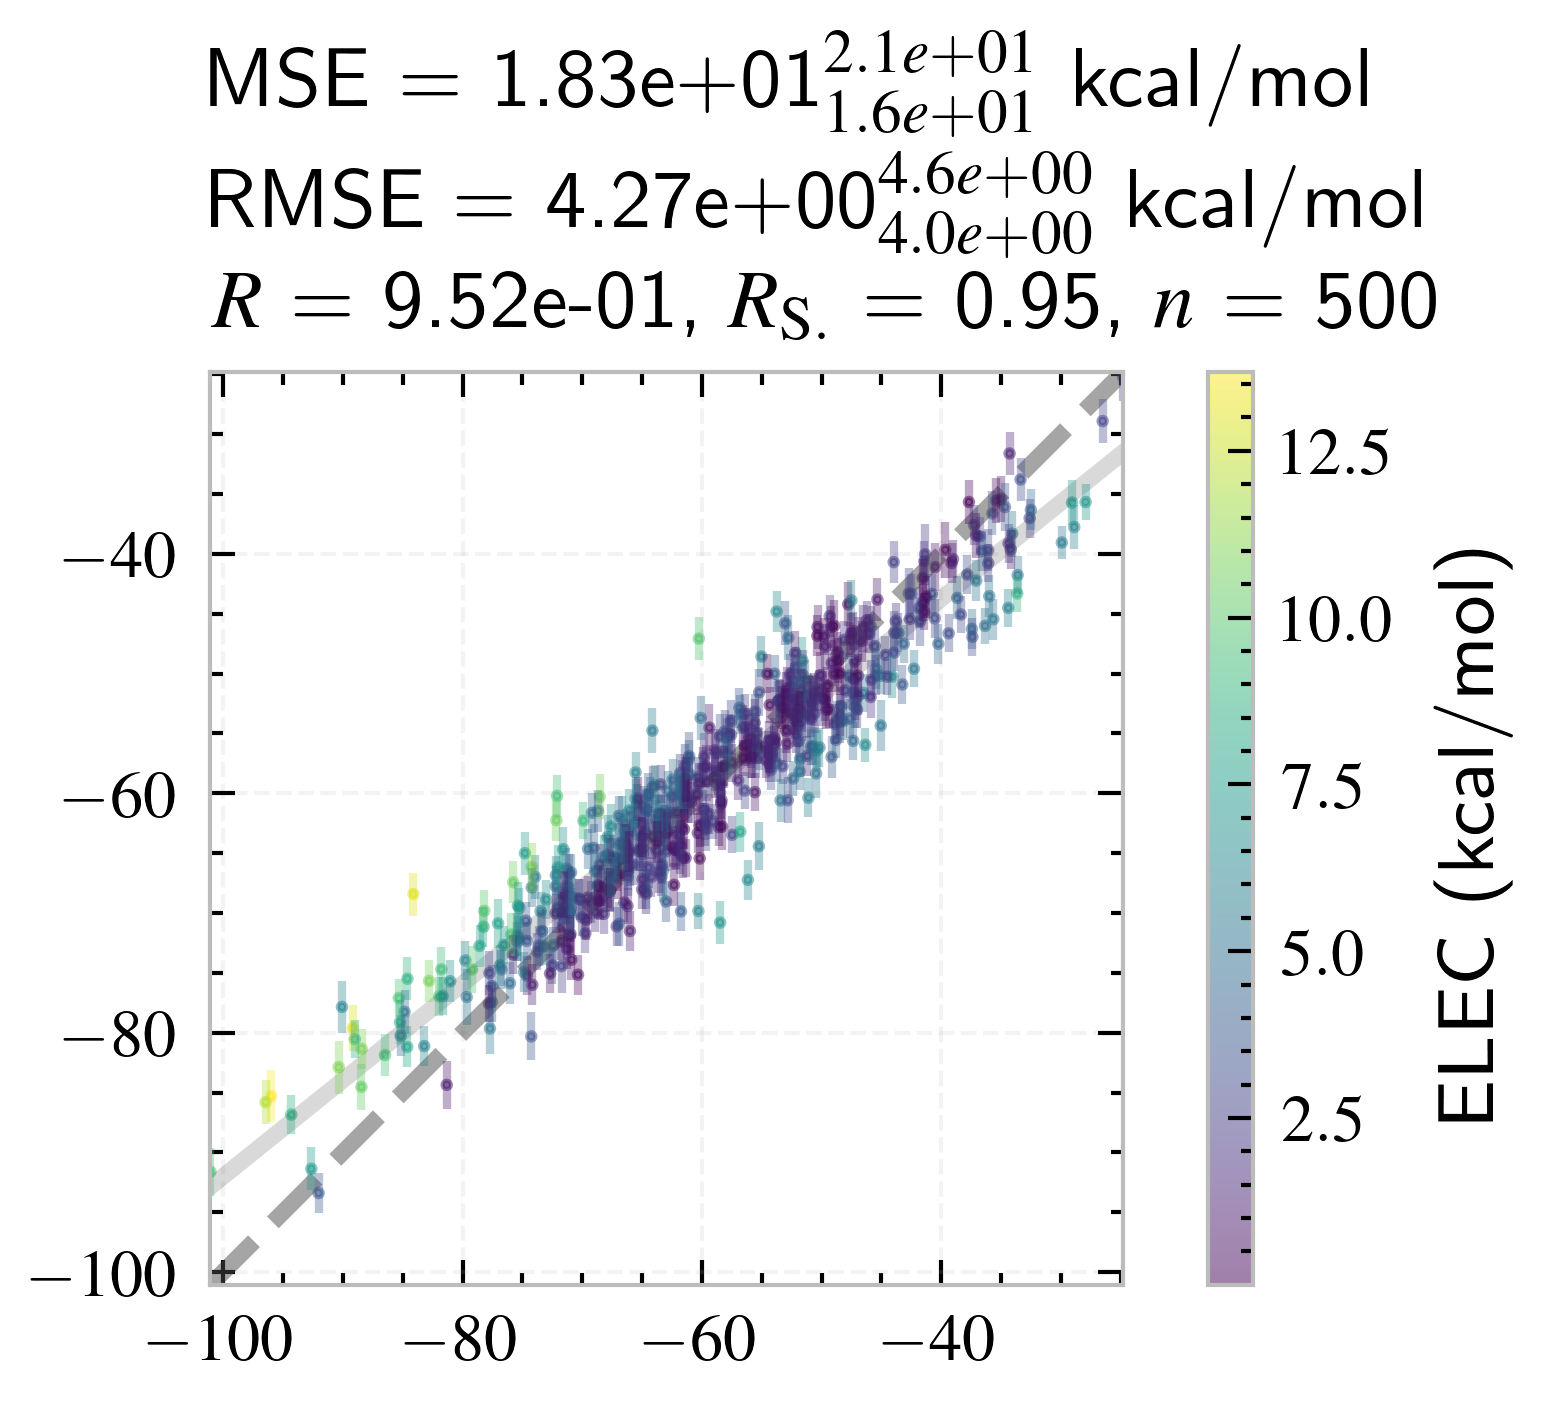

In [253]:
rng_key, rng_key_ = random.split(rng_key)
predictions_4 = Predictive(model, samples)(
    rng_key_,
    fit = _c.data["FITScaled"].values,
    targets = _c.data["TARGETScaled"].values,
    targets_sd = _c.data['manybody_diff_S'].abs().values
)

dset = _c.data

sd = dset.manybody_diff_S.abs().values

residuals_4 = dset.TARGETScaled.values - samples["fit_dist"]

residuals_mean = jnp.mean(residuals_4, axis=0)

residuals_hpdi = hpdi(residuals_4, 0.95)

# print(residuals_hpdi[1])
# print(residuals_mean)
err = abs(residuals_hpdi[1] - residuals_mean)

idx = jnp.argsort(residuals_mean)

y = jnp.arange(500)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))


# Plot Residuals
ax.plot(jnp.zeros(500), y, "--")
ax.errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=1, mew=4, ls="none", alpha=0.5
)

# Plot SD
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], ls="none", color="orange", alpha=0.5)


ax.set(xlabel="Residuals", ylabel="", title="Residuals with 90% CI")

ax.set_yticklabels([])

# ax.set_yticks(ticks = y)
# ax.set_yticklabels(np.array(dset.index)[idx], fontsize=4)
# plt.xlim(-1,1)
# plt.show()

plt.savefig("residuals.pdf", bbox_inches="tight")
plt.clf()



_c.data["pred_intE"] = _c.data["FIT"] + _c.data[_c.elec]

a, c, d = plot_energy_MSE(_c.data, "intE", "pred_intE", elec="manybody_diff",
                xlabel="", 
                ylabel="",
                s=1)

for i, (x, y, z) in enumerate(zip(_c.data["intE"], 
                                _c.data["pred_intE"], 
                                _c.data["manybody_diff"])):
    plt.errorbar(x, y, yerr=abs(err[i]*_c.data["FIT"].std()*2), 
                 linestyle="none", alpha=0.35, 
                 color=c.cmap(c.norm(z)), 
                 linewidth=1.)

# ax.text(
#     -2.8,
#     -7,
#     "Residuals (with error-bars) from current model (in red). "
#     "Black marker \nshows residuals from the previous model (Model 3). "
#     "Measurement \nerror is indicated by orange bar.",
# );

4.2478204923475553e-125


<ErrorbarContainer object of 3 artists>

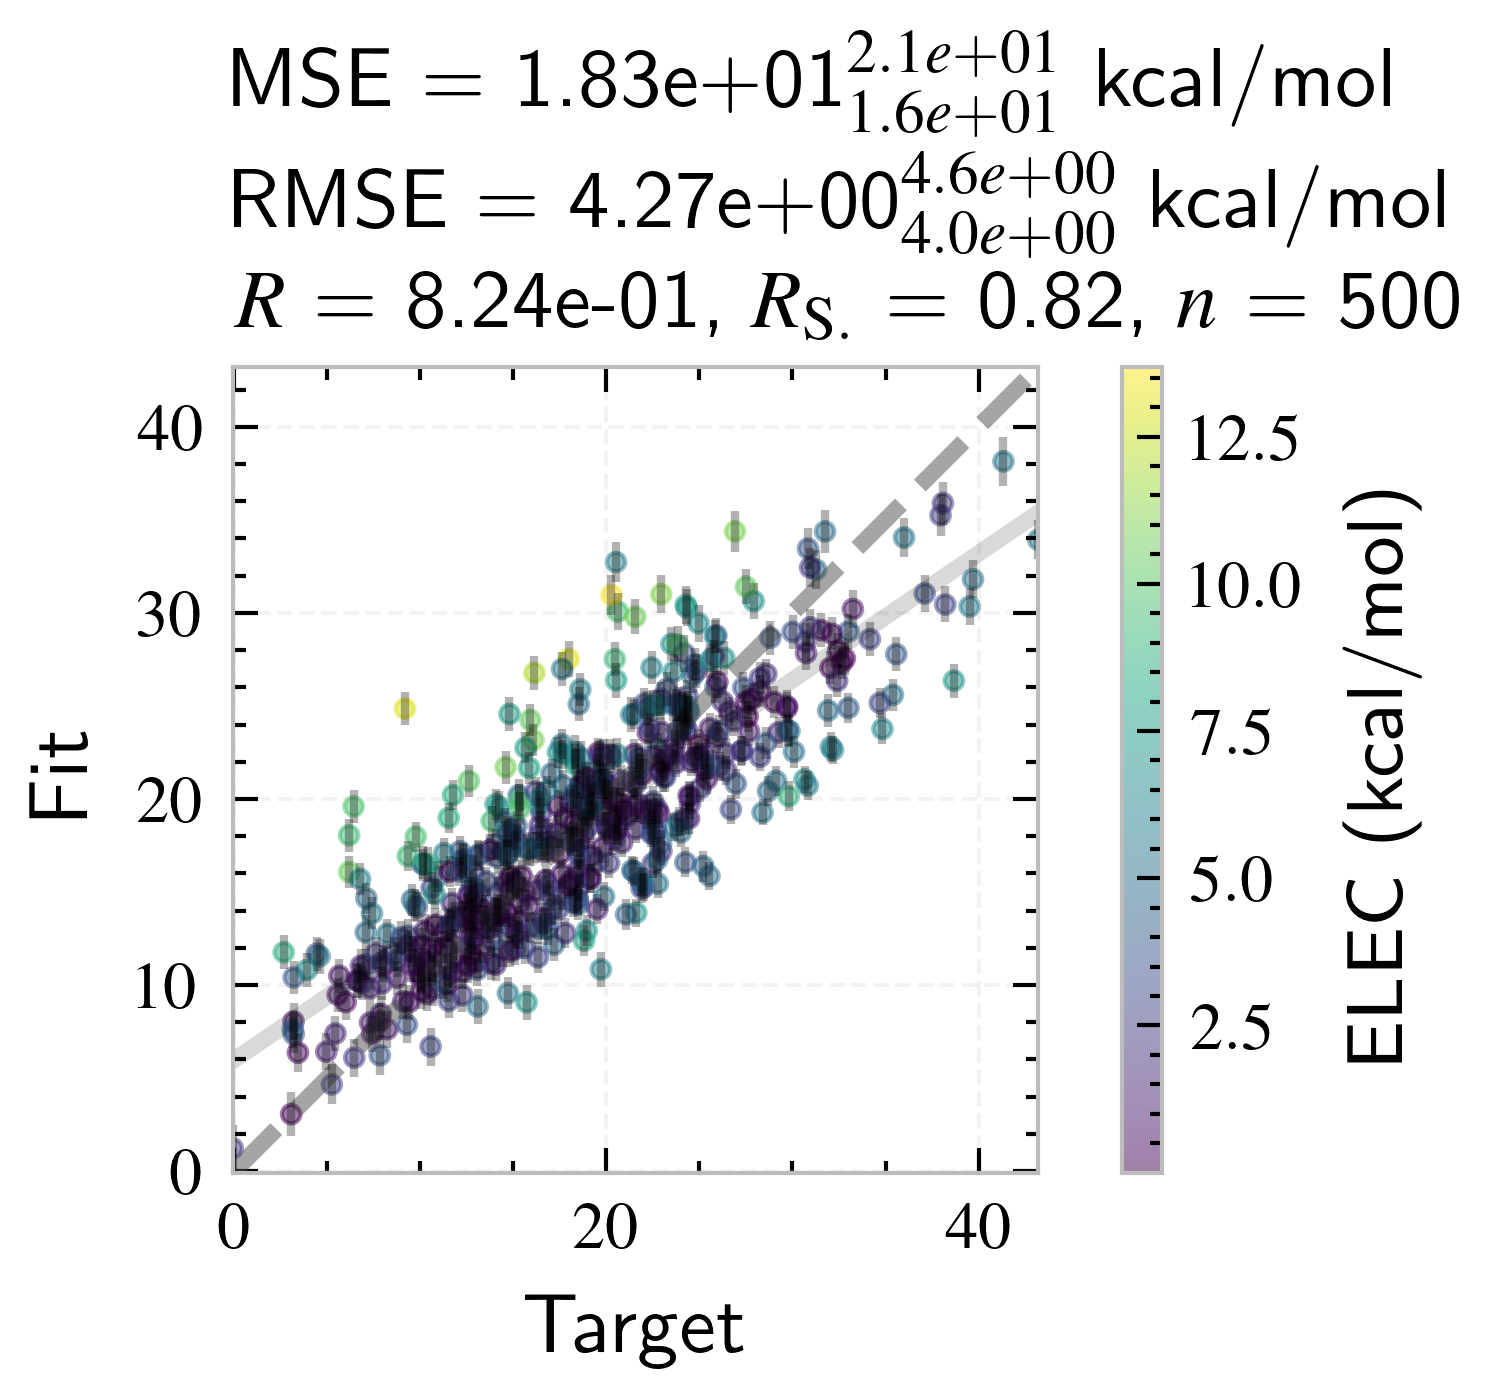

In [227]:
plt.rcParams['axes.facecolor'] = 'white'
plot_energy_MSE(_c.data, "TARGET", "FIT", elec="manybody_diff", xlabel="Target", ylabel="Fit",s=5)
plt.errorbar(_c.data["TARGET"], _c.data["FIT"], yerr=err*_c.data["FIT"].std(), 
             linestyle="none", alpha=0.3, color="k", linewidth=1)

1.3934683106291147e-258


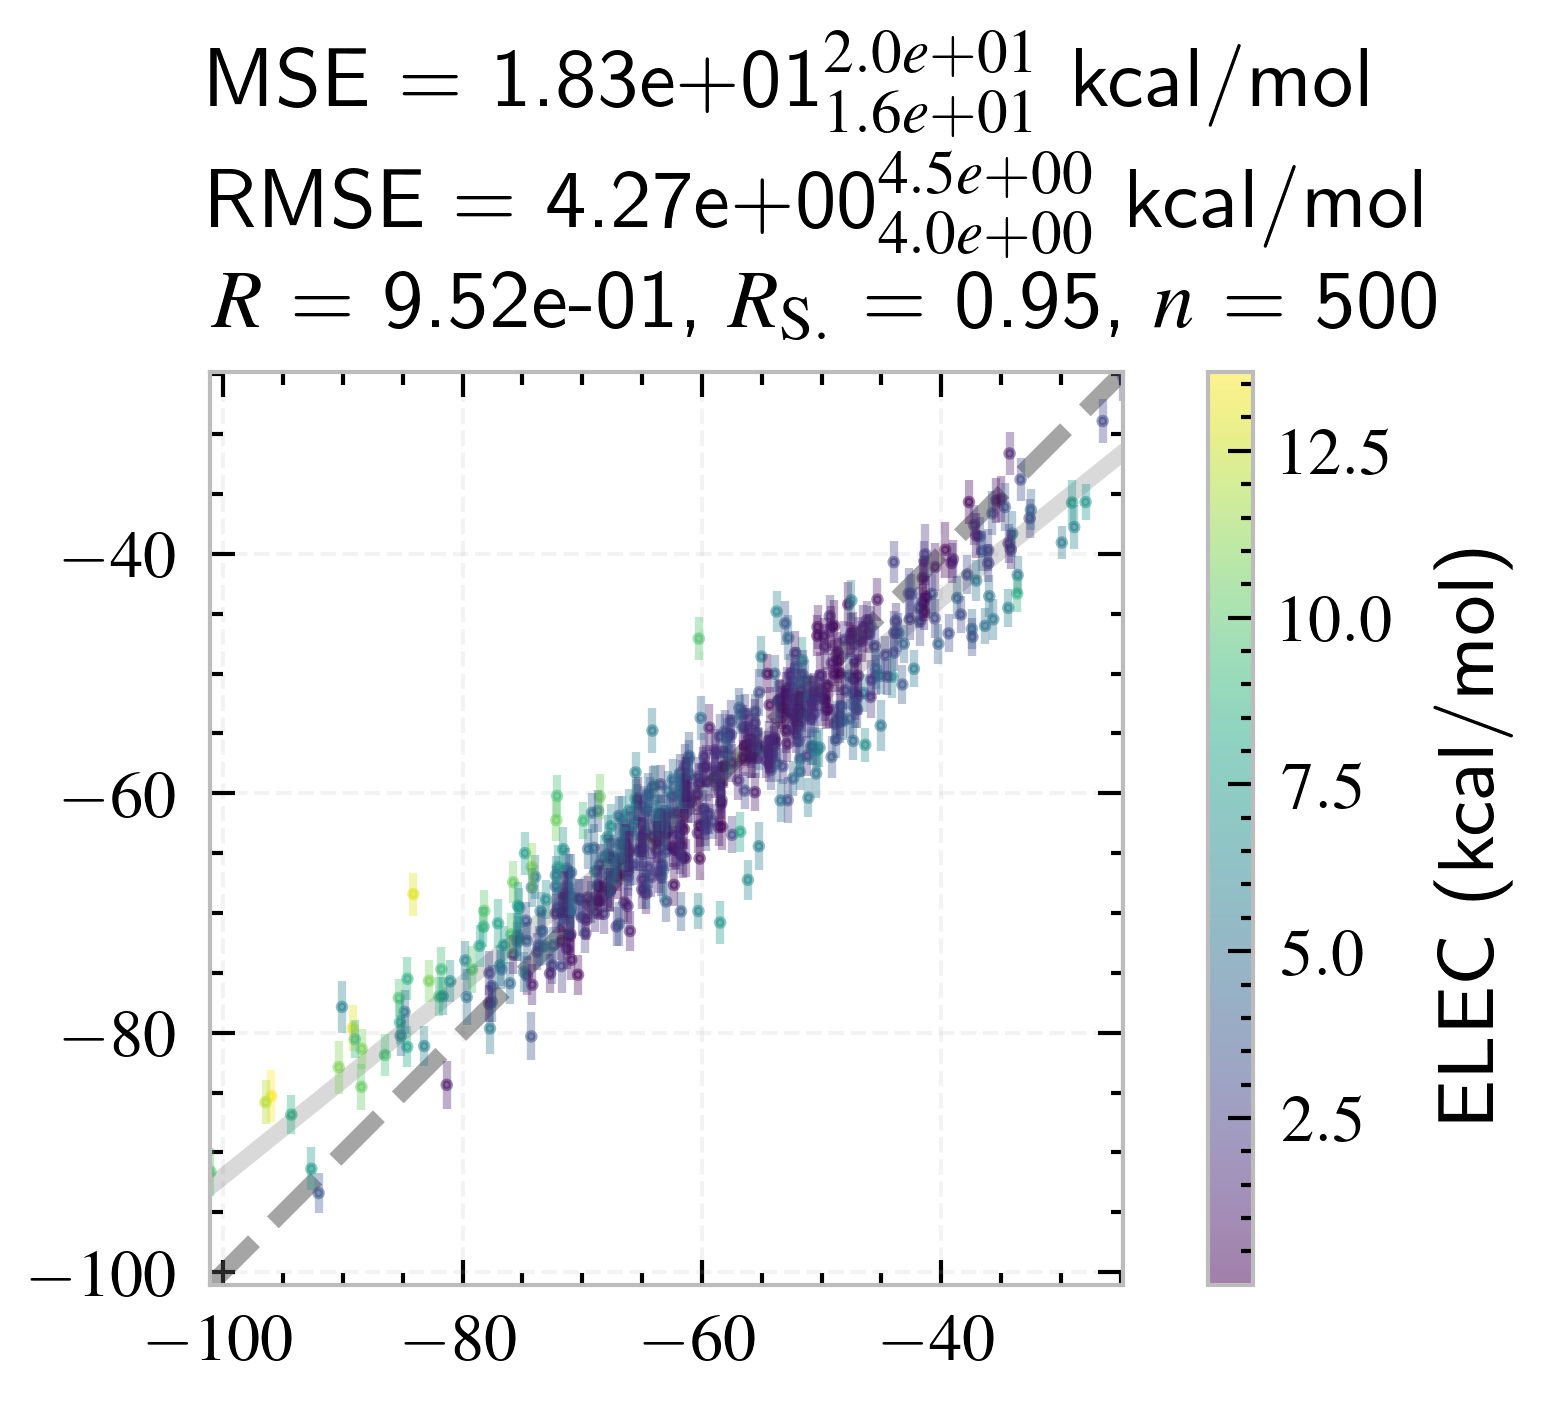

In [232]:
c.cmap(c.norm(1))

(0.28291, 0.105393, 0.426902, 1.0)